Les résultats du clustering ont identifié des groupes d'URL similaires dans les données de détection de fraude par carte de crédit. La méthode de clustering utilisée était K-means, avec un nombre de clusters défini à 5. La représentation des URL sous forme de vecteurs avec TF-IDF a permis de calculer la similarité entre les différentes URL.

L'évaluation des résultats du clustering à l'aide du coefficient de silhouette a donné un score de similarité moyen de 0,05, ce qui indique une faible qualité de la structure des clusters. Cela suggère que les URLs dans les clusters ne sont pas très similaires les unes aux autres.

Cependant, il est important de noter que les résultats de clustering peuvent varier en fonction des algorithmes de clustering et des paramètres utilisés. Il peut être nécessaire d'effectuer des ajustements supplémentaires ou d'essayer différents algorithmes de clustering pour obtenir des résultats plus significatifs. En outre, l'interprétation des résultats du clustering peut nécessiter une analyse plus approfondie des caractéristiques des données sous-jacentes.

                                                      url        type
536448             http://37.49.226.178/deusbins/deus.sh4     malware
40630   medical-dictionary.thefreedictionary.com/Galt+...      benign
630496                         www.jscape.com/sshfactory/    phishing
426724  http://www.wsnc.org.au/component/jcalpro/view/983  defacement
184034  virtualtourist.com/travel/North_America/Canada...      benign
                                                      url    type
count                                                5000    5000
unique                                               4994       4
top     http://www.thereefrestaurant.com/wp-content/pl...  benign
freq                                                    2    3278

--- ÉVALUATION DES CLUSTERS ---

K-means Calinski-Harabasz score: 149.65434549512005
DBSCAN n'a formé qu'un seul cluster, pas de score Calinski-Harabasz disponible.
HCA Calinski-Harabasz score: 794.2329748814976


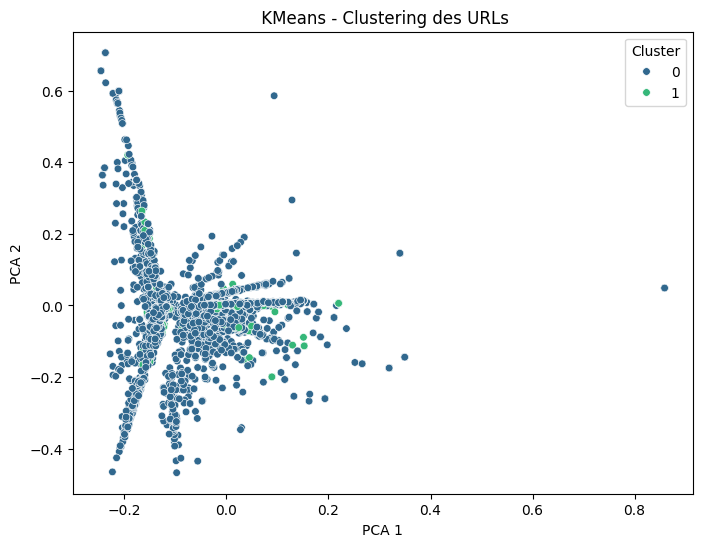

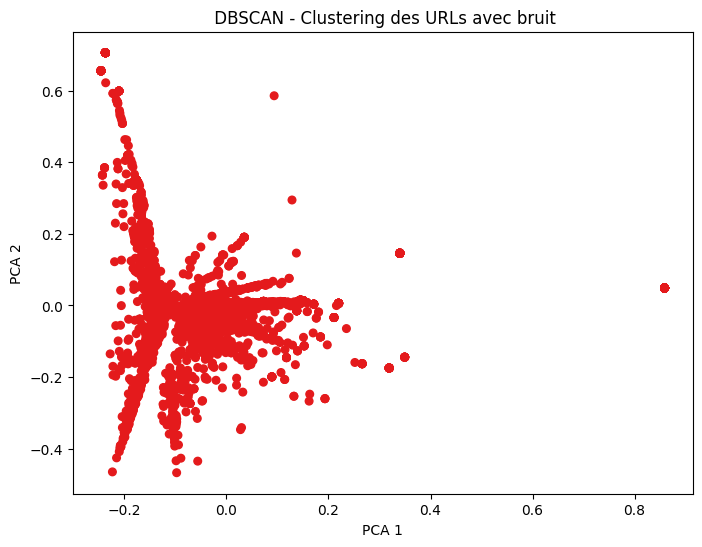

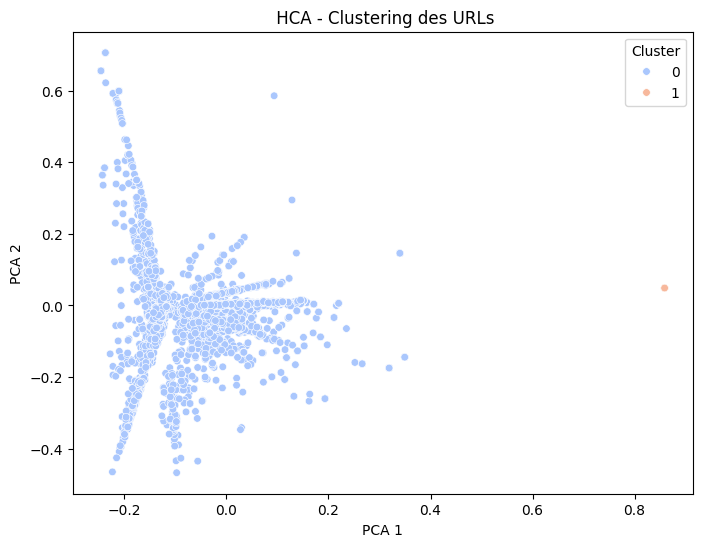

In [3]:
# 1. Chargement des données
import pandas as pd

data = pd.read_csv("malicious_phish.csv").sample(n=5000, random_state=42)


# 2. Analyse exploratoire
print(data.head())
print(data.describe())

# 3. Prétraitement avec TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)  # ou 1000 si tu veux aller plus vite
url_vectors = tfidf.fit_transform(data['url'])


# 4. Réduction de dimension avec TruncatedSVD (équivalent PCA pour sparse matrix)
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
url_vectors_reduced = svd.fit_transform(url_vectors)

# 5. Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# K-means
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(url_vectors_reduced)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan.fit(url_vectors_reduced)

# HCA
hca = AgglomerativeClustering(n_clusters=2)
hca.fit(url_vectors_reduced)

# 6. Évaluation des clusters
from sklearn.metrics import silhouette_score, calinski_harabasz_score

print("\n--- ÉVALUATION DES CLUSTERS ---\n")

# Calinski-Harabasz Score pour K-means
print("K-means Calinski-Harabasz score:", calinski_harabasz_score(url_vectors_reduced, kmeans.labels_))

# Calinski-Harabasz Score pour DBSCAN (ajout d'un contrôle sur les labels)
if len(set(dbscan.labels_)) > 1:  # Vérifie si plus d'un cluster a été formé
    print("DBSCAN Calinski-Harabasz score:", calinski_harabasz_score(url_vectors_reduced, dbscan.labels_))
else:
    print("DBSCAN n'a formé qu'un seul cluster, pas de score Calinski-Harabasz disponible.")

# Calinski-Harabasz Score pour HCA (ajout d'un contrôle sur les labels)
if len(set(hca.labels_)) > 1:  # Vérifie si plus d'un cluster a été formé
    print("HCA Calinski-Harabasz score:", calinski_harabasz_score(url_vectors_reduced, hca.labels_))
else:
    print("HCA n'a formé qu'un seul cluster, pas de score Calinski-Harabasz disponible.")

# 7. Visualisation en 2D (PCA pour afficher)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Réduction à 2 composantes pour affichage
pca = PCA(n_components=2)
url_vectors_2d = pca.fit_transform(url_vectors_reduced)

# --- Visualisation KMeans ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=url_vectors_2d[:, 0], y=url_vectors_2d[:, 1], hue=kmeans.labels_, palette='viridis', s=30)
plt.title(" KMeans - Clustering des URLs")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

# --- Visualisation DBSCAN ---
dbscan_labels = dbscan.labels_
unique_labels = set(dbscan_labels)
palette = sns.color_palette("Set1", len(unique_labels))
colors = [palette[label] if label != -1 else (0, 0, 0) for label in dbscan_labels]

plt.figure(figsize=(8,6))
plt.scatter(url_vectors_2d[:, 0], url_vectors_2d[:, 1], c=colors, s=30)
plt.title(" DBSCAN - Clustering des URLs avec bruit")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# --- Visualisation HCA ---
plt.figure(figsize=(8,6))
sns.scatterplot(x=url_vectors_2d[:, 0], y=url_vectors_2d[:, 1], hue=hca.labels_, palette='coolwarm', s=30)
plt.title(" HCA - Clustering des URLs")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

